# Cyclicity Analysis of Financial Time-Series

We will use the procedure of Cyclicity Analysis to extract leader-follower relations within the following categories of financial time-series: 

* Daily Stock Prices
* Intraday Stock Prices
* Intraday Cryptocurrency Prices

In [1]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/StockMarketAnalysis')
from CyclicityAnalysis import *
from FetchPrices import *
from LeaderFollowerFrequencyAnalysis import *
from joblib import Parallel, delayed
import os
import requests
import json
import scipy as sc
import scipy.signal
from bs4 import BeautifulSoup

# Fetching S&P 500 Sector Companies

The $500$ most influential companies in the Stock Market are divided into $11$ different categories, known as $\textbf{S&P 500 sectors (indices)}.$ These sectors are listed below.

* Comsumer Discretionary: https://www.tradingview.com/symbols/SP-S5COND/components/
* Financials: https://www.tradingview.com/symbols/SP-SPF/components/
* Energy: https://www.tradingview.com/symbols/SP-SPN/components/
* Information Technology: https://www.tradingview.com/symbols/SP-S5INFT/components/
* Health Care: https://www.tradingview.com/symbols/SP-S5HLTH/components/
* Materials: https://www.tradingview.com/symbols/SP-S5MATR/components/
* Consumer Staples: https://www.tradingview.com/symbols/SP-S5CONS/components/
* Communication Services: https://www.tradingview.com/symbols/SP-S5TELS/components/
* Real Estate: https://www.tradingview.com/symbols/SP-S5REAS/components/
* Industrials: https://www.tradingview.com/symbols/SP-S5INDU/components/
* Utilities: https://www.tradingview.com/symbols/SP-S5UTIL/components/

In the code cell below, we obtain the list of companies belonging to an S&P 500 sector. The companies are represented using their stock market abbreviations.

In [2]:
SP_500_sector_trading_view_abbrevs_dict= ['Consumer Discretionary','Financials','Energy',
                                          'Information Technology', 'Health Care', 'Materials',
                                          'Consumer Staples', 'Communication Services', 
                                          'Real Estate', 'Industrials', 'Utilities']

def get_SP_500_sector_stock_abbrevs(sector_name):
    file_path="S&P 500 Companies/{}.csv".format(sector_name)
    SP_500_sector_stock_abbrevs_df=pd.read_csv(file_path,index_col=0)    
    SP_500_sector_stock_abbrevs= list(SP_500_sector_stock_abbrevs_df[SP_500_sector_stock_abbrevs_df.columns[0]].unique())

    return SP_500_sector_stock_abbrevs


SP_500_sector_names=['Consumer Discretionary','Financials','Energy','Information Technology', 
                     'Health Care', 'Materials', 'Consumer Staples', 'Communication Services', 
                     'Real Estate', 'Industrials', 'Utilities']

print(get_SP_500_sector_stock_abbrevs("Financials"))

['AFL', 'AIG', 'AIZ', 'AJG', 'ALL', 'AMP', 'AON', 'AXP', 'BAC', 'BEN', 'BK', 'BLK', 'BRK.B', 'BRO', 'C', 'CB', 'CBOE', 'CFG', 'CINF', 'CMA', 'CME', 'COF', 'DFS', 'FITB', 'FRC', 'GL', 'GS', 'HBAN', 'HIG', 'ICE', 'IVZ', 'JPM', 'KEY', 'L', 'LNC', 'MCO', 'MET', 'MKTX', 'MMC', 'MS', 'MSCI', 'MTB', 'NDAQ', 'NTRS', 'PBCT', 'PFG', 'PGR', 'PNC', 'PRU', 'RE', 'RF', 'RJF', 'SCHW', 'SIVB', 'SPGI', 'STT', 'SYF', 'TFC', 'TROW', 'TRV', 'USB', 'WFC', 'WLTW', 'WRB', 'ZION']


# Cyclicity Analysis: Daily Stock Prices

Select $N$ companies from the Stock Market. Let $T= \lbrace t_m \rbrace_{m=1}^n$ be the collection of timestamps with $t_1$ being the timestamp corresponding to January 4th, 2010, $t_n$ being the timestamp corresponding to the most recent trading day, and $t_m$ being the timestamp corresponding to $m$ trading days since January 4th, 2010.
For each $k \in \lbrace 1, \ \dots \ , N \rbrace,$ let $\left \lbrace x^{(k)}_{t_m} \right \rbrace_{m=1}^n$ be the time-series with $x^{(k)}_{t_m}$ being the end of day closing stock price of company $k$ at the timestamp $t_m.$ We fetch this data from Polygon.IO. We run Cyclicity Analysis on these N time-series.

## Data Preprocessing

For each $k,$ we preprocess the time-series $\left \lbrace x^{(k)}_{t_m} \right \rbrace_{m=1}^n$ as follows. Let $D=\left \lbrace m \in \lbrace 1, \ \dots \ , n \rbrace: x^{(k)}_{t_m} \ne \emptyset \right \rbrace.$ 

* $\textbf{Logarithm}:$ We compute the time-series $\left \lbrace \widetilde{x^{(k)}_{t_m}} \right \rbrace_{m=1}^n,$ where $\widetilde{x^{(k)}_{t_m}}= \ln \left(x^{(k)}_{t_m} \right)$ if $m \in D$ and $\emptyset$ otherwise.
* $\textbf{Detrending}:$ We perform linear regression on the set $\left \lbrace \left (m,  \widetilde{x^{(k)}_{t_m}} \right): m \in D \right \rbrace.$ Let $\widehat{y}: D \rightarrow \mathbb{R}$ be the best fit line. We compute the time series $\left \lbrace \widetilde{\widetilde{x^{(k)}_{t_m}}} \right \rbrace_{m=1}^n,$ where $\widetilde{\widetilde{x^{(k)}_{t_m}}}=\widetilde{x^{(k)}_{t_m}} - \widehat{y}(m)$ if $m \in D$ and $\emptyset$ otherwise. 

* $\textbf{Normalization}:$ We compute the $\ell^2$ norm $$\left \| \left \lbrace \widetilde{\widetilde{x^{(k)}_{t_m}}} \right \rbrace \right \|_2= \sqrt{\sum_{j \in D} \left(\widetilde{\widetilde{x^{(k)}_{t_j}}} \right)^2}$$ and compute $\left \lbrace \widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}} \right \rbrace_{m=1}^n,$ where $\widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}} =\frac{\widetilde{\widetilde{x^{(k)}_{t_m}}}}{\left \| \left \lbrace \widetilde{\widetilde{x^{(k)}_{t_m}}} \right \rbrace \right \|_2}$ if $m \in D$ and $\emptyset$ otherwise.

* $\textbf{Imputing}:$ If $\widetilde{\widetilde{\widetilde{x^{(k)}_{t_j}}}}= \emptyset,$ we set $\widetilde{\widetilde{\widetilde{x^{(k)}_{t_j}}}} :=  \widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}}$ where $m \in D$ is the largest index such that $m \le j,$ provided it exists. If $m$ does not exist, we let $\widetilde{\widetilde{\widetilde{x^{(k)}_{t_j}}}} :=  \widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}}$ where $m \in D$ is the smallest index such that $m \ge j.$

* $\textbf{Translation}:$ We compute $\left \lbrace \widetilde{\widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}}} \right \rbrace_{m=1}^n,$ where $\widetilde{\widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}}}=\widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}} - \widetilde{\widetilde{\widetilde{x^{(k)}_{t_1}}}}.$ 

The resulting time-series $\left \lbrace \widetilde{\widetilde{\widetilde{\widetilde{x^{(k)}_{t_m}}}}} \right \rbrace_{m=1}^n$ is what we call the preprocessed time-series. We plot these time-series below for certain companies. 

$\textbf{Note}:$ For any daily stock price time-series, we assume it has already been preprocessed using the procedure above.

In the code cell below, we obtain the daily stock prices for the big tech companies and some investment banks. 

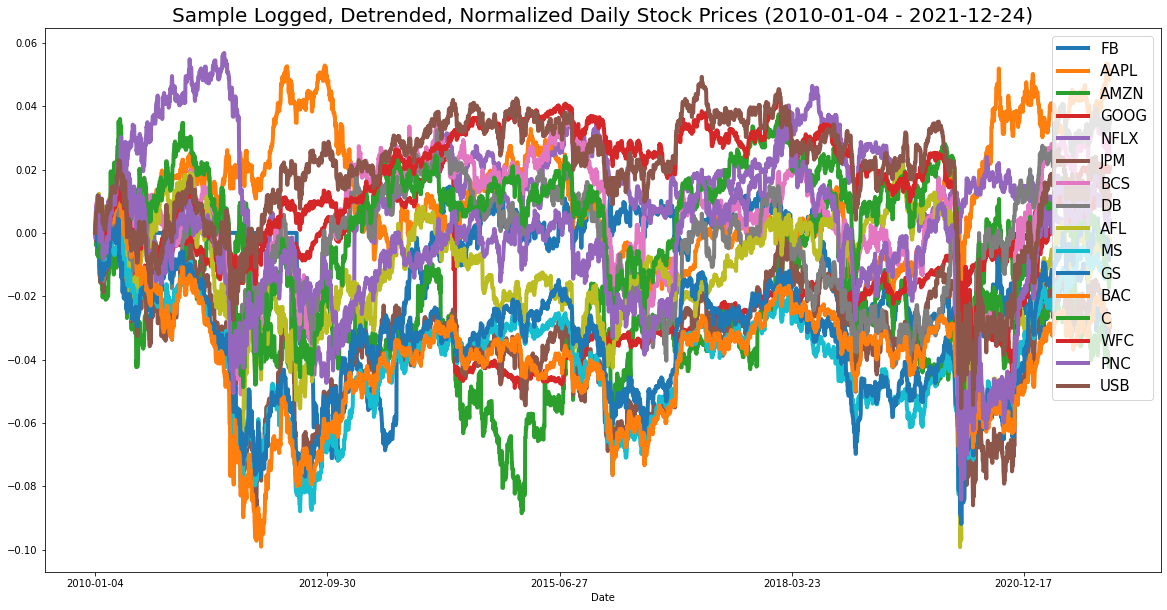

In [3]:
stock_abbrevs=['FB','AAPL','AMZN','GOOG','NFLX','JPM','BCS','DB','AFL','MS','GS','BAC','C','WFC','PNC','USB']
start_date, end_date = '2010-01-04', today
daily_stock_prices_df=FetchPrices(stock_abbrevs,'stock').fetch_daily_prices_df(start_date, end_date)

plot_df(daily_stock_prices_df, 
        title ='Sample Logged, Detrended, Normalized Daily Stock Prices ({} - {})'.format(daily_stock_prices_df.index[0], 
                                                                                          daily_stock_prices_df.index[-1]),
        linewidth=4.0)

## Lead-Lag Matrix

In the code cell below, we output the heatmap representation of the $N \times N$ lead-lag matrix corresponding to our $N$ preprocessed time-series.

In [4]:
Daily_CA=CyclicityAnalysis(daily_stock_prices_df)
Daily_CA.plot_lead_lag_df(color_label='Oriented Area')

## Top 10 Leader Follower Pairs

We plot the top $10$ pairs of time-series with highest oriented areas (precedence strengths) according to the heatmap, along with their corresponding accumulated oriented area plots throughout the decade.

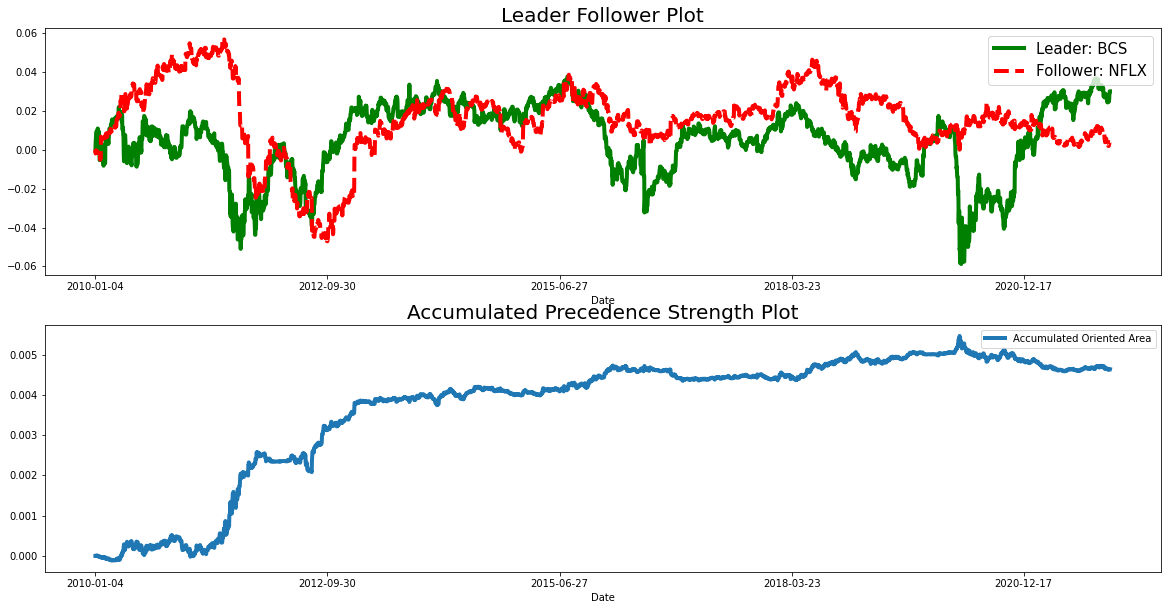

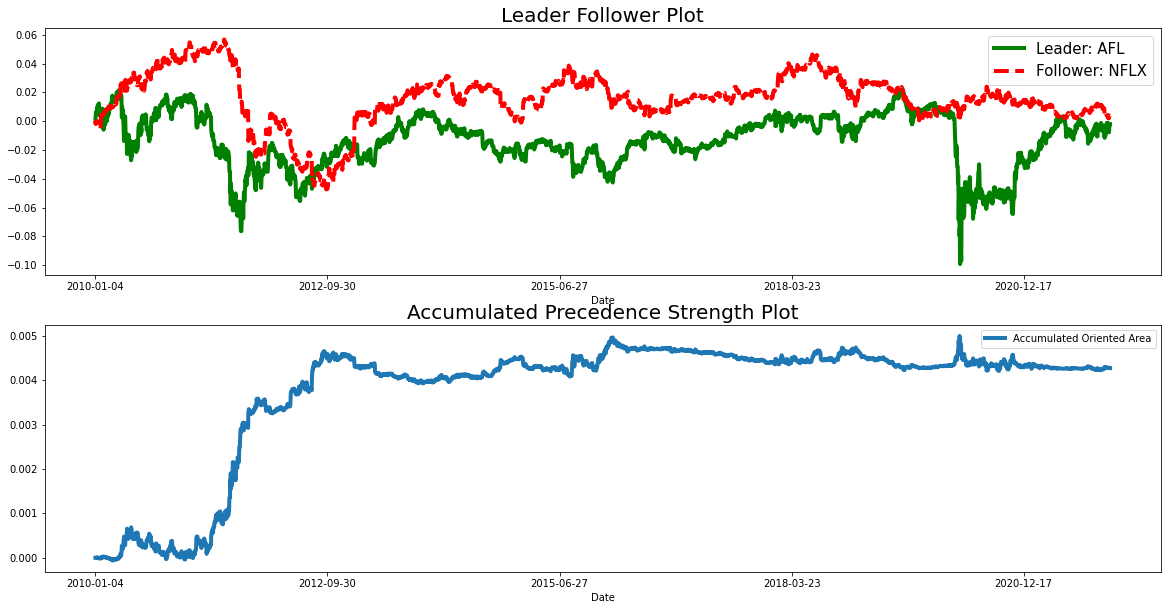

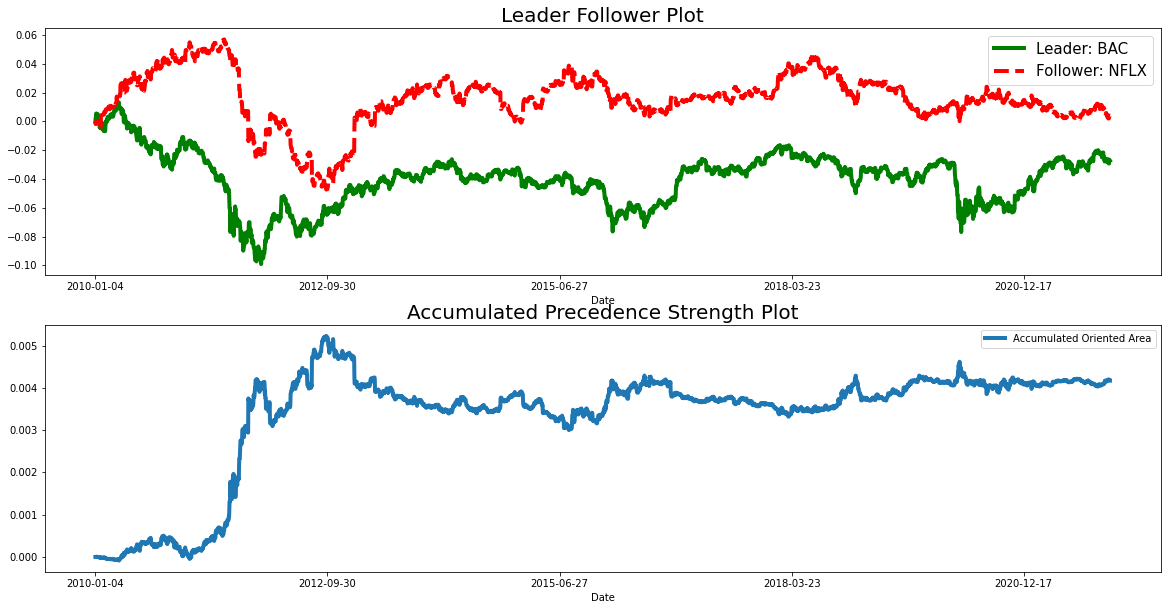

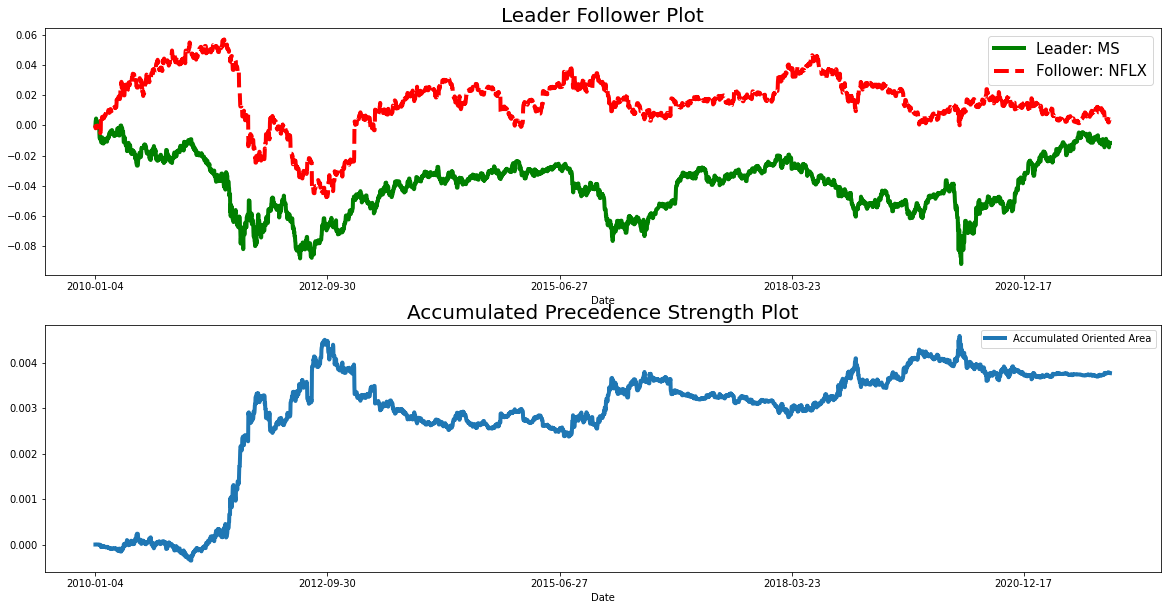

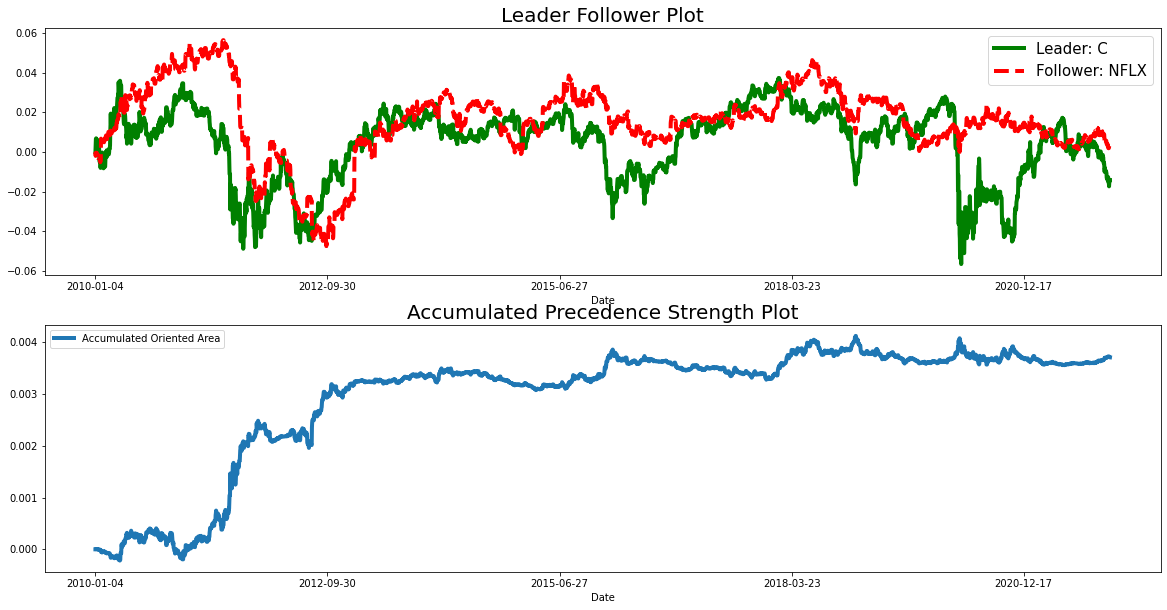

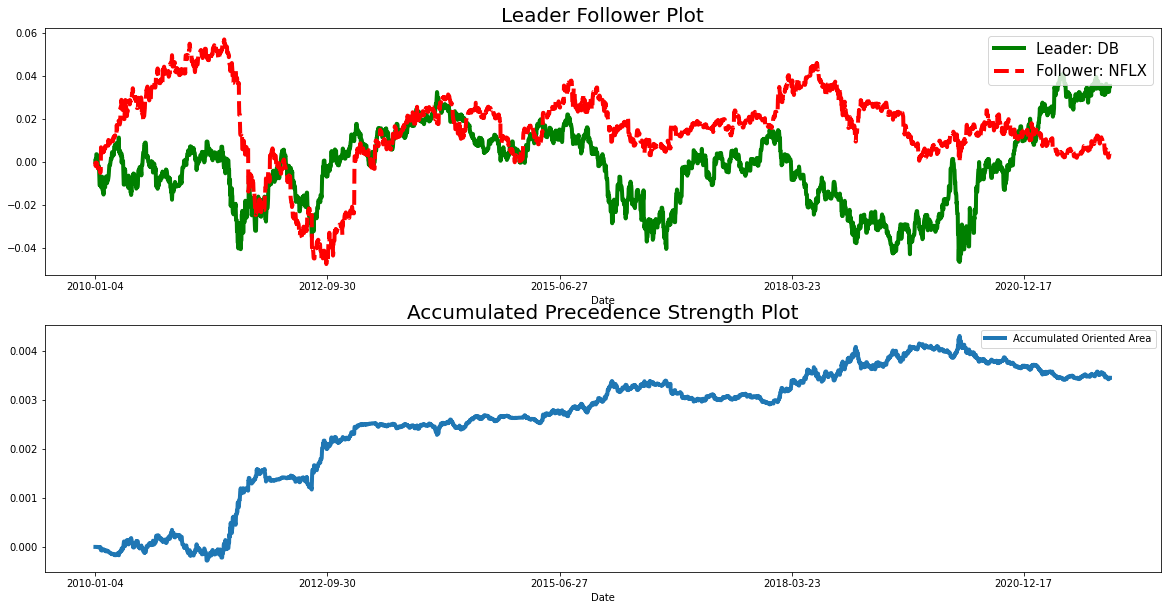

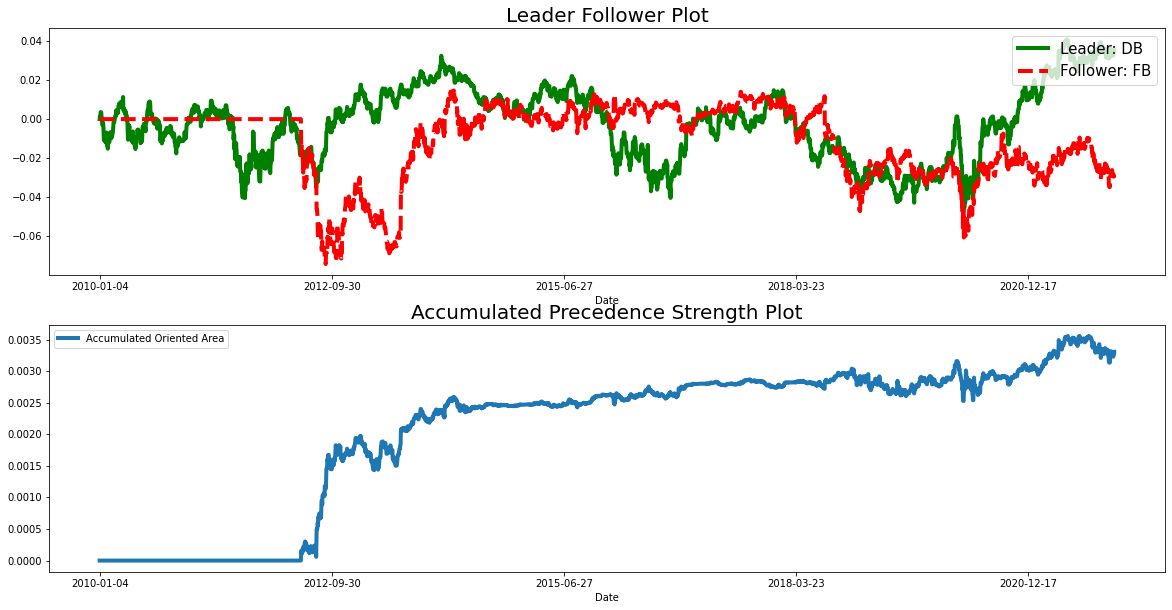

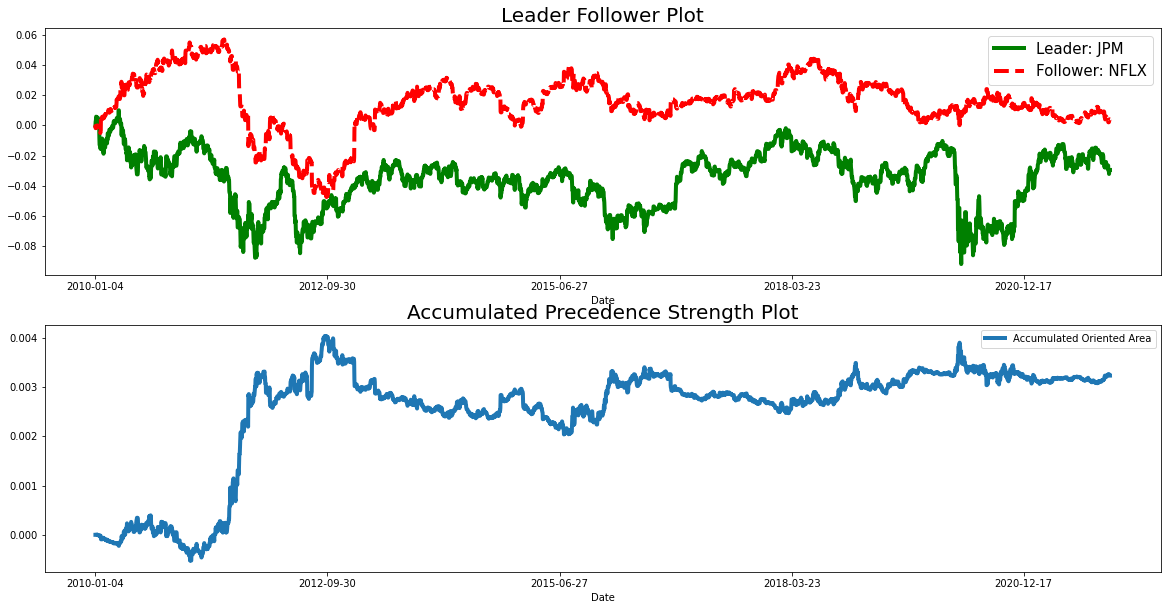

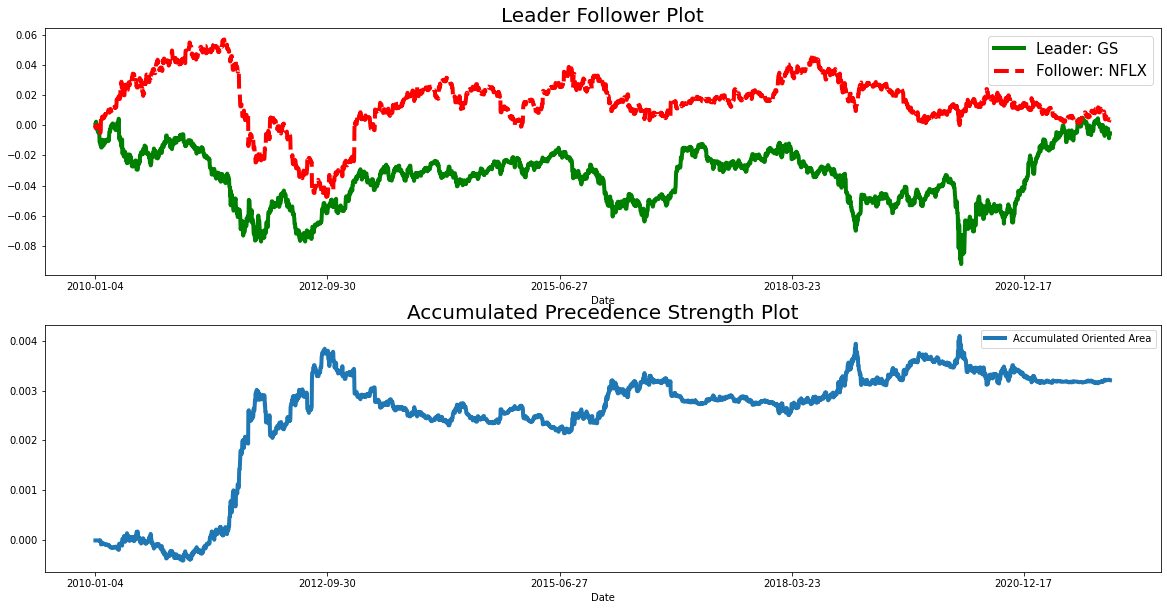

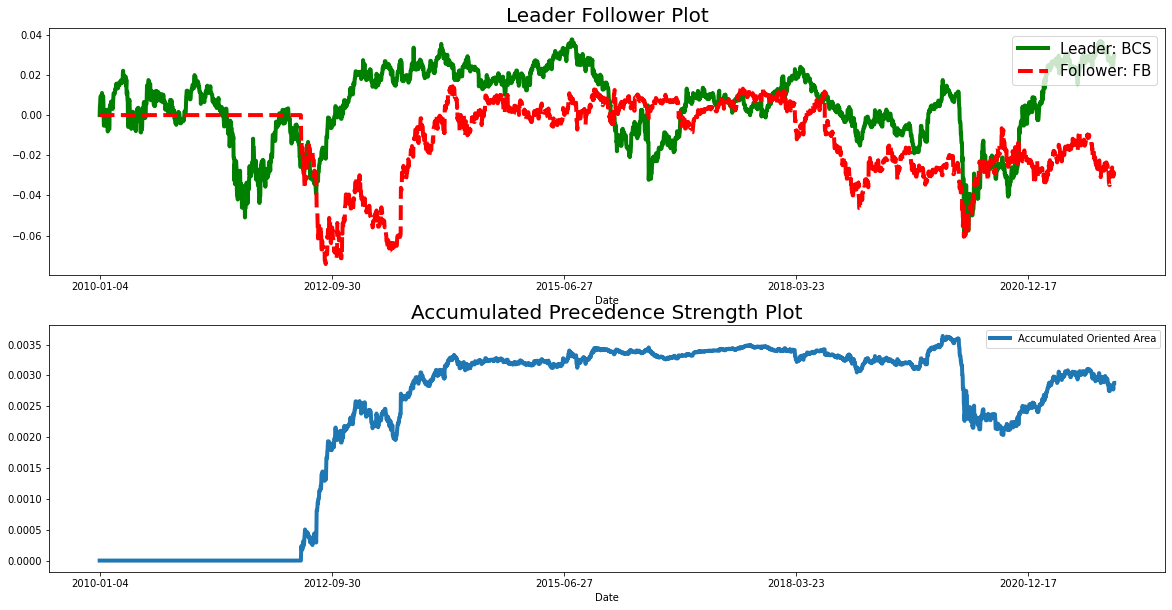

In [5]:
top_pairs = Daily_CA.get_topN_leader_follower_pairs(N=10)
for pair in top_pairs:
    leader, follower = pair
    plot_leader_follower_relationship(daily_stock_prices_df, leader, follower, 
                                      include_accumulated_oriented_area_plot= True)

# Cyclicity Analysis: Intraday Stock Prices

Now, fix a particular trading day. Let $T=\lbrace t_m \rbrace_{m=1}^n$ be the collection of timestamps with $t_1$ being the timestamp corresponding to 9:30 A.M. EST of that trading day and $t_n$ being the timestamp corresponding to 4:00 P.M. EST of that trading day, and each $t_m$ being the timestamp corresponding to $m$ minutes after 9:30 A.M. EST of that trading day (which means $n=391$). 

For each $k \in \lbrace 1, \ \dots \ , N \rbrace,$ let $\left \lbrace x^{(k)}_{t_m} \right \rbrace_{m=1}^n$ be the time-series with $x^{(k)}_{t_m}$ being the stock price of company $k$ at the timestamp $t_m.$ We preprocess each time-series $\left \lbrace x^{(k)}_{t_m} \right \rbrace_{m=1}^n$ by following the procedure for normalization, imputing, and translating.

We implement the data fetching from Polygon.io and preprocessing of intraday stock price time-series. We plot the preprocessed time-series of all companies from the financial sector for today's date. 

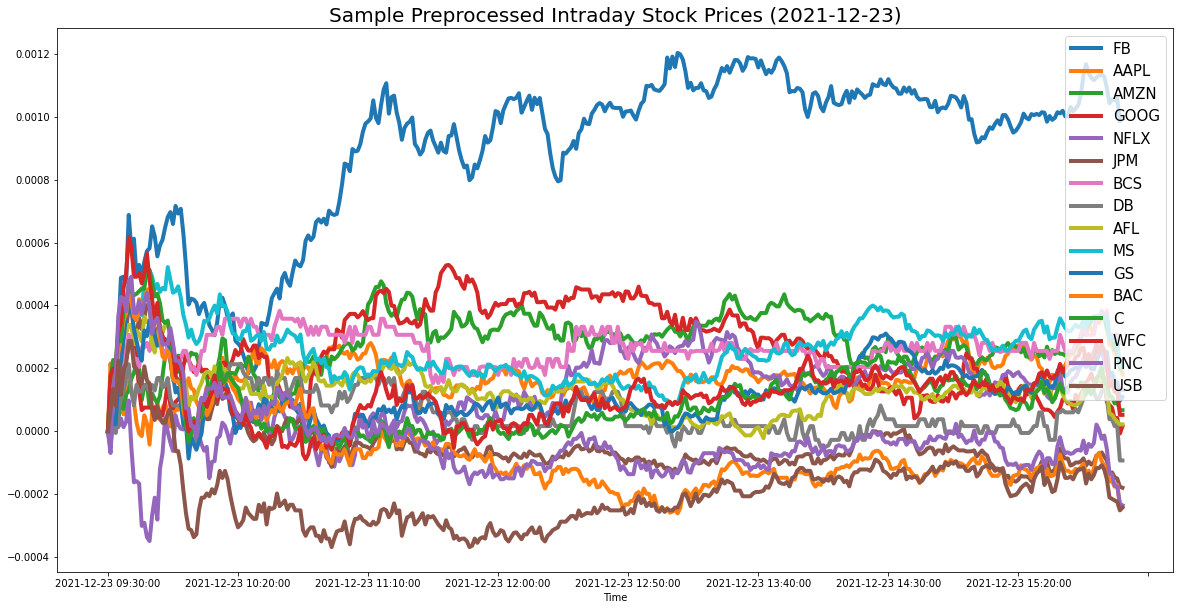

In [6]:
date='2021-12-23'
intraday_stock_prices_df=FetchPrices(stock_abbrevs,'stock').fetch_intraday_prices_df(date)
plot_df(intraday_stock_prices_df, 
        title ='Sample Preprocessed Intraday Stock Prices ({})'.format(date),
        linewidth=4.0)

## Lead Lag Matrix

We run Cyclicity Analysis on the intraday stock price time-series. We output the heatmap of the lead lag matrix.

In [7]:
Intraday_CA=CyclicityAnalysis(intraday_stock_prices_df)
Intraday_CA.plot_lead_lag_df()

## Top 10 Leader Follower Pairs

We obtain the the top $10$ pairs of intraday stock price time-series with the highest oriented areas according to the heatmap. For each pair, we plot the leader follower relationship and their accumulated precedence strength throughout the trading day.

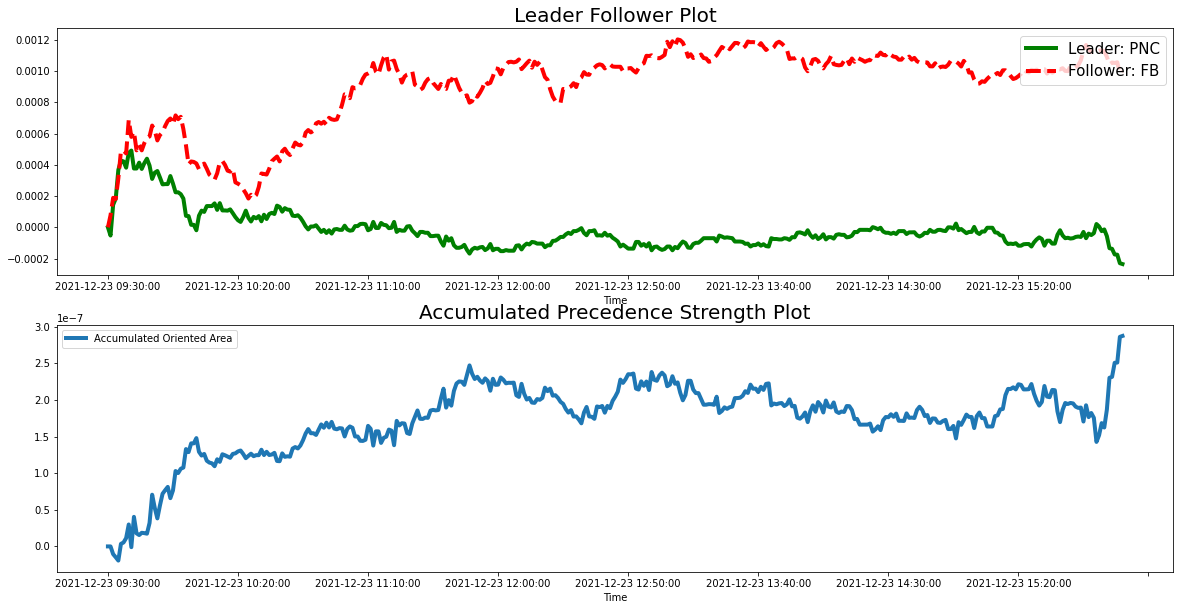

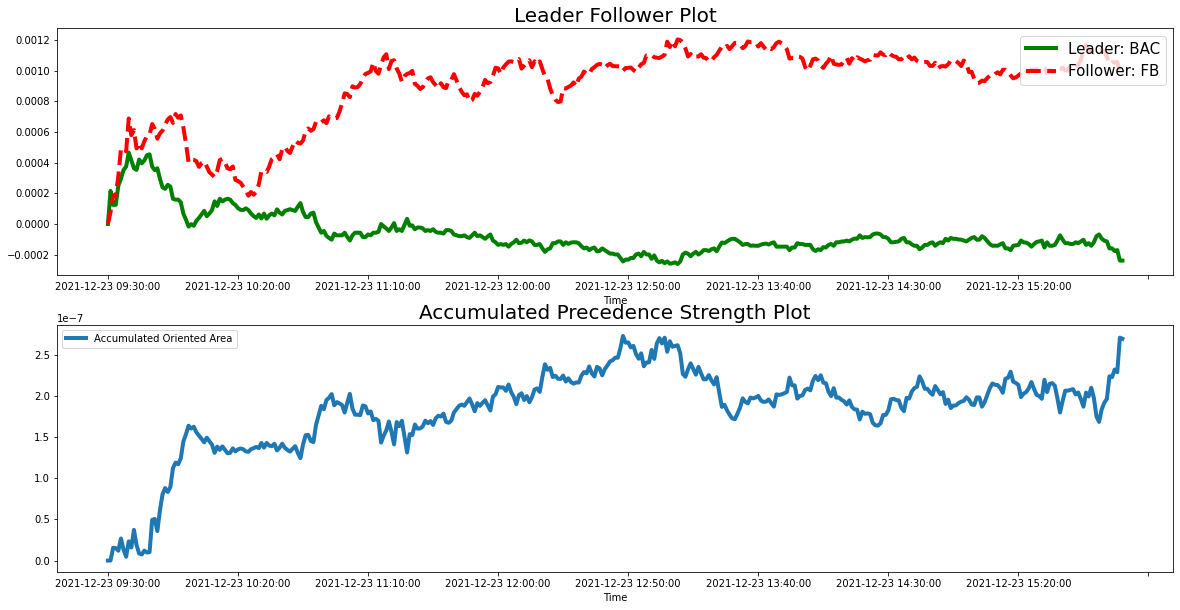

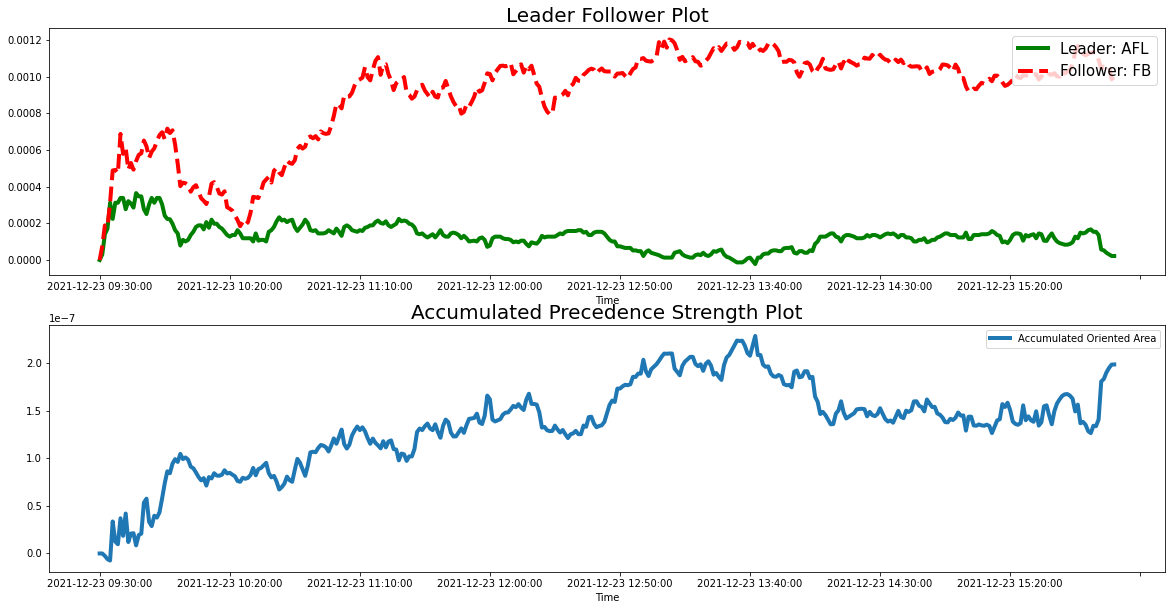

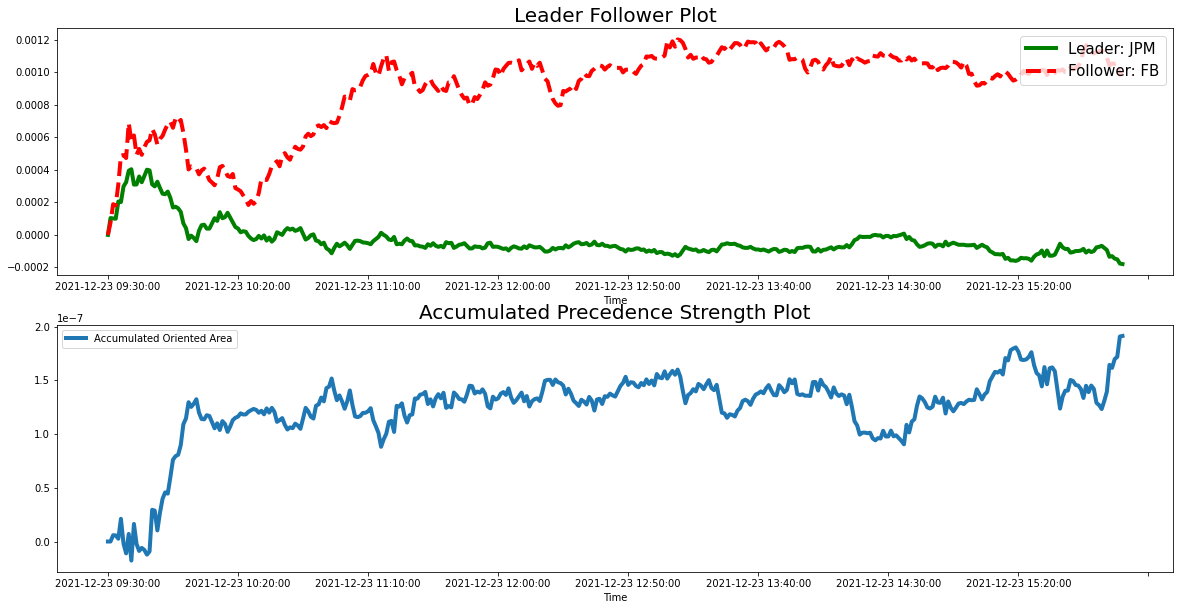

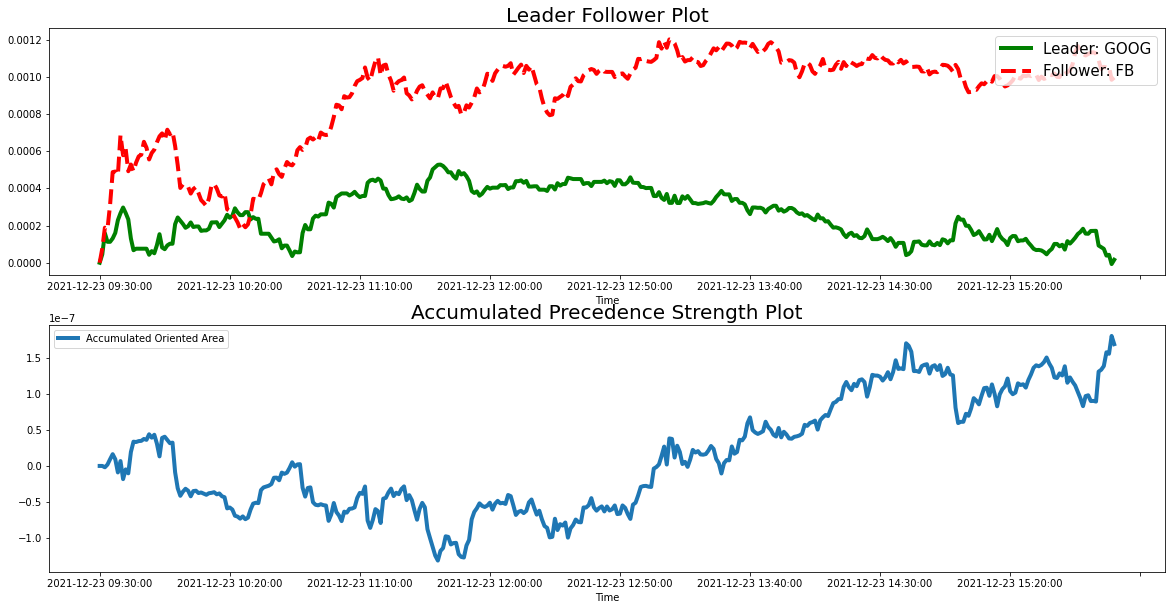

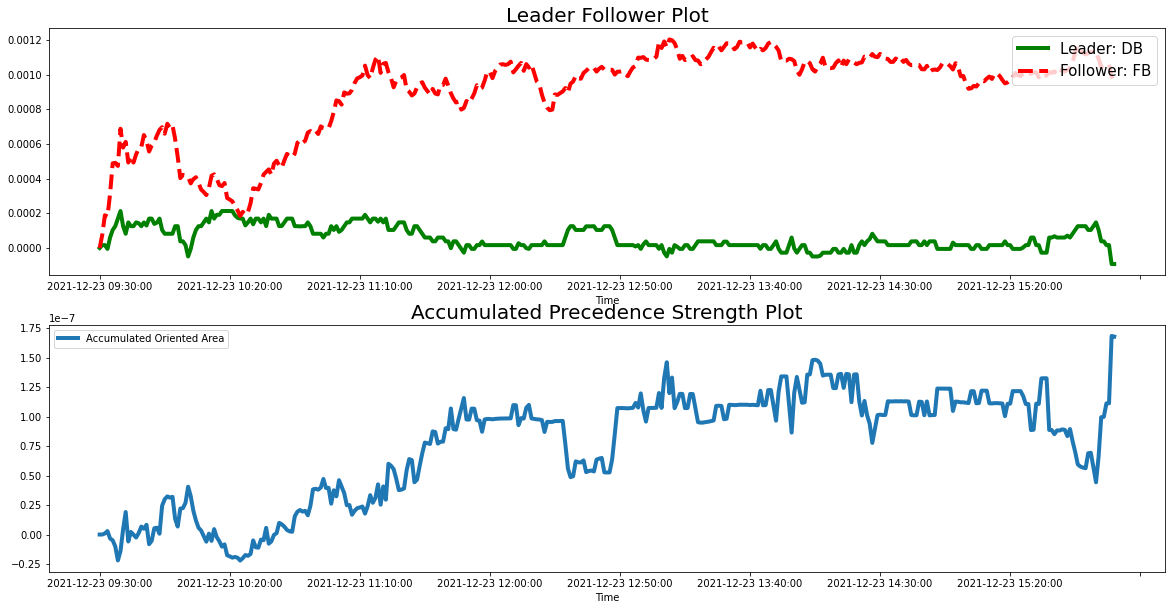

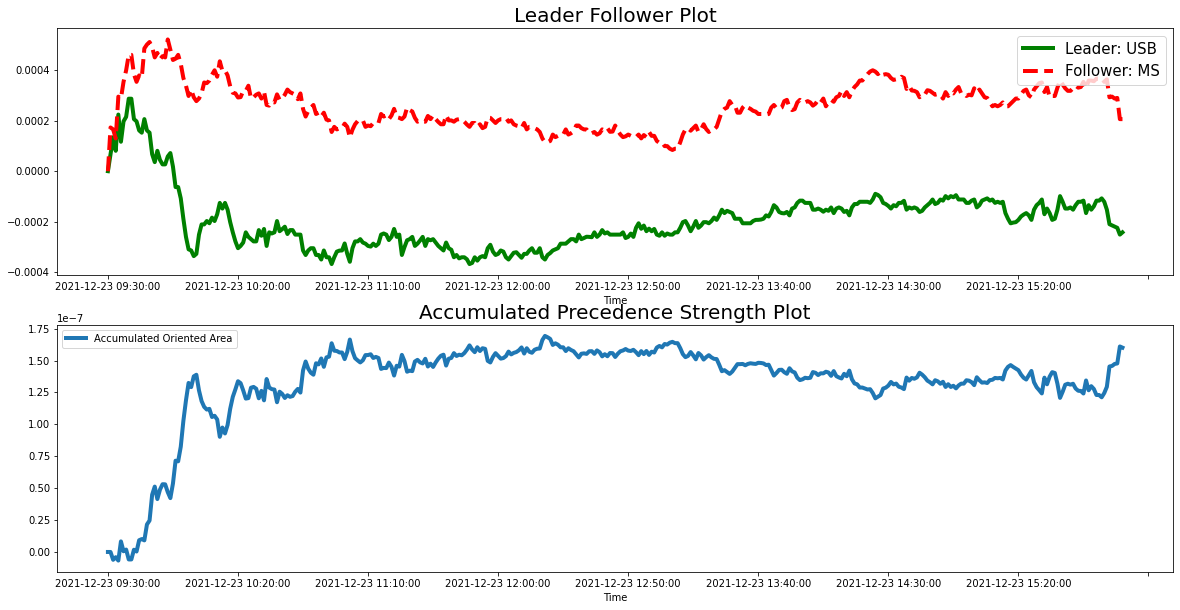

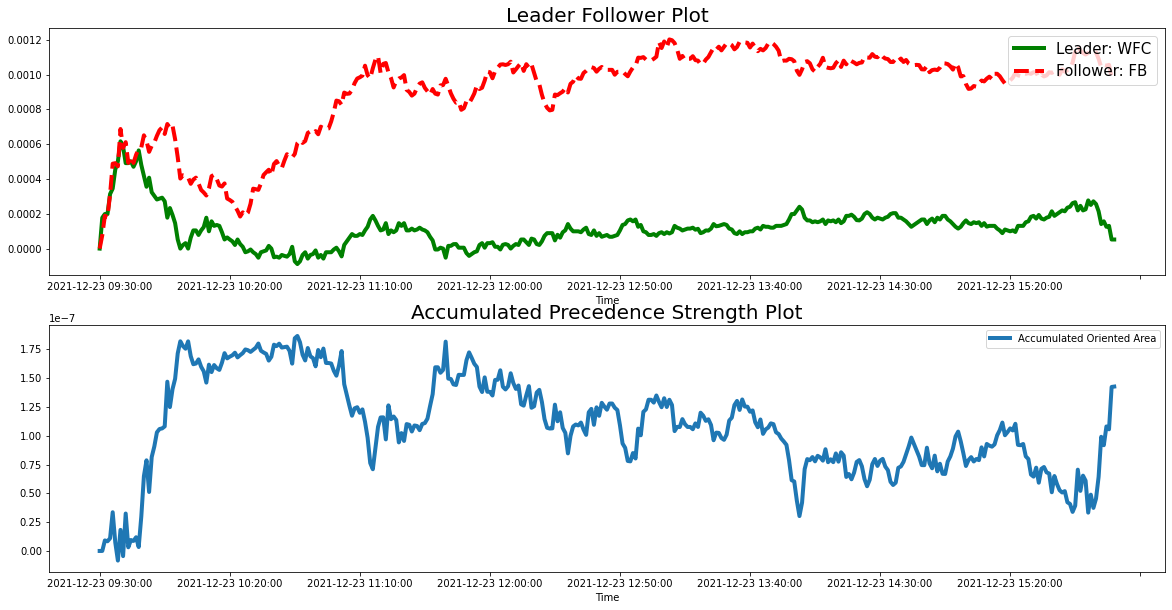

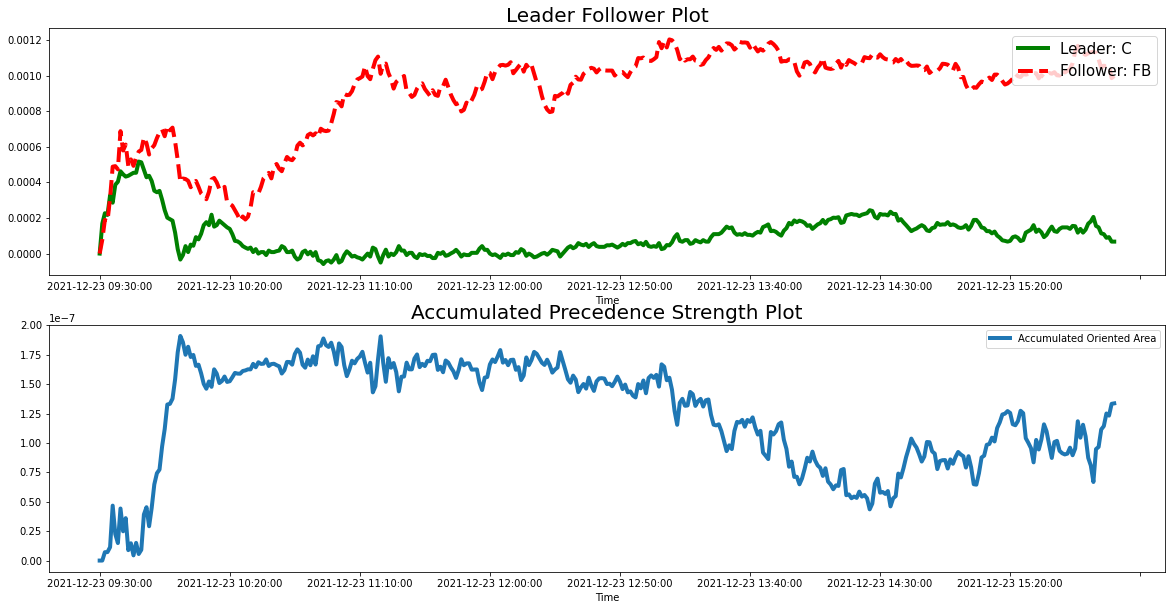

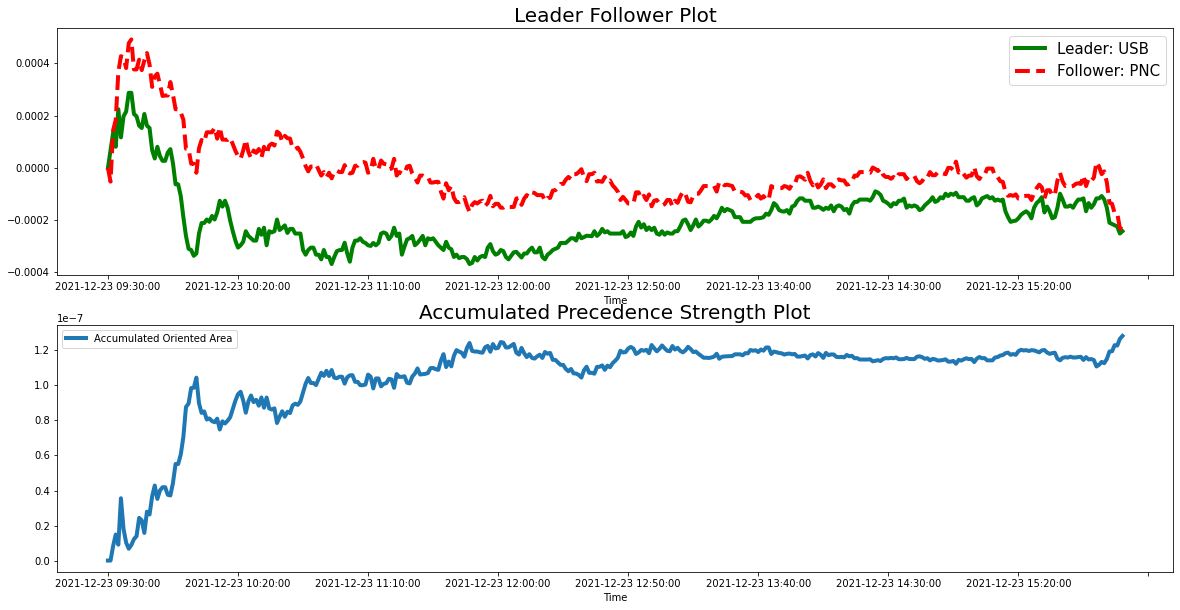

In [8]:
for pair in Intraday_CA.get_topN_leader_follower_pairs(N=10):
    leader,follower=pair
    plot_leader_follower_relationship(intraday_stock_prices_df, 
                                      leader, 
                                      follower, 
                                      figsize=(20,10))

## Obtaining Top 10 Strong Leader Follower Company Pairs Per 2021 Trading Day

For each 2021 trading day, we run Cyclicity Analysis for the $N$ corresponding stock price time-series and obtain the top $10$ leader follower company pairs for that day. We implement this in the code cell below.

In [9]:
start_date, end_date ='2021-12-01', '2021-12-23'
LFA=LeaderFollowerFrequencyAnalysis(stock_abbrevs,'stock',start_date,end_date)
LFA.get_topN_intraday_leader_follower_df(end_date)

SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-01 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-02 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-03 ...
FAILED OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-04 ...
FAILED OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-05 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-06 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-07 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-08 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-09 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-10 ...
FAILED OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-11 ...
FAILED OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-12 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-13 ...
SUCCESS OBTAINING TOP 10 INTRADAY LEADER FOLLOWERS FOR 2021-12-14 ...
SUCCESS OBTAINING TOP 10

Leader Follower
Date                      
2021-12-23    PNC       FB
2021-12-23    BAC       FB
2021-12-23    AFL       FB
2021-12-23    JPM       FB
2021-12-23   GOOG       FB
2021-12-23     DB       FB
2021-12-23    USB       MS
2021-12-23    WFC       FB
2021-12-23      C       FB
2021-12-23    USB      PNC

## Obtaining 2021 Trading Days Of Strong Leader Follower Relationships

For the $j$-th and $k$-th intraday time-series, we obtain the list of all $2021$ trading days for which their leader follower relationship was strong. These are the days in which the oriented area for their respective intraday time-series was amongst the top $10.$ We implement this in the code cell below.

In [10]:
LFA.strong_leader_follower_relationship_days_df

Leader Follower  Number of Strong Leader Follower Dates  \
0       FB     GOOG                                       5   
1     AAPL      PNC                                       4   
2        C       FB                                       4   
3       FB     AMZN                                       4   
4     AAPL     AMZN                                       4   
..     ...      ...                                     ...   
96      FB      USB                                       1   
97    GOOG      AFL                                       1   
98    GOOG        C                                       1   
99    GOOG       FB                                       1   
100    WFC      USB                                       1   

                          Strong Leader Follower Dates  
0    [2021-12-01, 2021-12-06, 2021-12-15, 2021-12-1...  
1     [2021-12-10, 2021-12-14, 2021-12-16, 2021-12-20]  
2     [2021-12-08, 2021-12-13, 2021-12-21, 2021-12-23]  
3     [2021-12-06, 2021-12-15, 2021-12-21, 2021-12-22]  
4     [2021-12-06, 2021-12-08, 2021-12-10, 2021-12-15]  
..                                                 ...  
96                                        [2021-12-09]  
97                                        [2021-12-20]  
98                                        [2021-12-15]  
99                                        [2021-12-23]  
100                                       [2021-12-08]  

[101 rows x 4 columns]

## Strong Frequency Count Matrix of 2021 Trading Days 

For the $j$-th and $k$-th intraday time-series, we obtain $C_{j,k},$ which is the number of $2021$ trading days for which their leader follower relationship was strong. We construct the $N \times N$ matrix $C,$ whose $(j,k)$-th entry is $C_{j,k}.$ We call this the $\textbf{strong frequency count matrix.}$ We output a heatmap representation below.

In [11]:
LFA.plot_strong_frequency_count_df()

## S&P 500 Sector Frequency Count Matrix for 2021

For each S&P 500 sector, we obtain the available companies and obtain the corresponding strong  frequency count matrix for $2021.$

In [12]:
def SP_500_leader_follower_intraday_analysis(sector_name, start_date = '2021-01-01', end_date = today):
    stock_abbrevs = get_SP_500_sector_stock_abbrevs(sector_name)
    save_directory='S&P_500_{}_Top_Intraday_Leader_Followers'.format(sector_name)
    LFA=LeaderFollowerFrequencyAnalysis(stock_abbrevs,'stock',start_date,end_date,save_directory)
    
    if end_date == today:
        LFA.get_topN_intraday_leader_follower_df(date=end_date,update=True)
        
    LFA.plot_strong_frequency_count_df(title="{} Frequency Matrix ({} - {})".format(sector_name, start_date, end_date))
    return LFA.strong_leader_follower_relationship_days_df


for sector_name in SP_500_sector_names:
    print("FETCHING {} Strong Frequency Count Matrix ...".format(sector_name))
    start_date, end_date ='2021-12-22', '2021-12-23'
    strong_leader_follower_relationship_days_df=SP_500_leader_follower_intraday_analysis(sector_name, 
                                                                                         start_date,
                                                                                         end_date)
    print(strong_leader_follower_relationship_days_df.head(5))

FETCHING Consumer Discretionary Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    AZO      KMX                                       1   
1    CCL      AZO                                       1   
2   TSLA      RCL                                       1   
3   TSLA     NCLH                                       1   
4   TSLA      LVS                                       1   

  Strong Leader Follower Dates  
0                 [2021-12-22]  
1                 [2021-12-22]  
2                 [2021-12-23]  
3                 [2021-12-23]  
4                 [2021-12-23]  
FETCHING Financials Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    AMP     CBOE                                       1   
1   CBOE     MKTX                                       1   
2   SIVB     MSCI                                       1   
3   SCHW     MKTX                                       1   
4   SCHW     CBOE                                       1   

  Strong Leader Follower Dates  
0                 [2021-12-22]  
1                 [2021-12-22]  
2                 [2021-12-22]  
3                 [2021-12-22]  
4                 [2021-12-22]  
FETCHING Energy Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    MPC      APA                                       2   
1    MPC      DVN                                       1   
2    SLB      APA                                       1   
3    PXD     CTRA                                       1   
4    PXD      APA                                       1   

  Strong Leader Follower Dates  
0     [2021-12-22, 2021-12-23]  
1                 [2021-12-22]  
2                 [2021-12-23]  
3                 [2021-12-22]  
4                 [2021-12-23]  
FETCHING Information Technology Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0   ANET     CDAY                                       1   
1   CTXS     CDAY                                       1   
2   XLNX     CTXS                                       1   
3   PAYX     XLNX                                       1   
4   PAYX      STX                                       1   

  Strong Leader Follower Dates  
0                 [2021-12-23]  
1                 [2021-12-23]  
2                 [2021-12-23]  
3                 [2021-12-22]  
4                 [2021-12-22]  
FETCHING Health Care Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0   ABMD     MRNA                                       1   
1   ALGN     ABMD                                       1   
2   XRAY     MRNA                                       1   
3    WST     MRNA                                       1   
4    WST     ABMD                                       1   

  Strong Leader Follower Dates  
0                 [2021-12-23]  
1                 [2021-12-22]  
2                 [2021-12-22]  
3                 [2021-12-22]  
4                 [2021-12-23]  
FETCHING Materials Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    ALB       CF                                       1   
1    AVY       CF                                       1   
2    SHW      NEM                                       1   
3    SEE      NEM                                       1   
4    SEE      ALB                                       1   

  Strong Leader Follower Dates  
0                 [2021-12-22]  
1                 [2021-12-23]  
2                 [2021-12-23]  
3                 [2021-12-23]  
4                 [2021-12-22]  
FETCHING Consumer Staples Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0   BF.B      HSY                                       1   
1   BF.B       KR                                       1   
2    WBA      STZ                                       1   
3    WBA       PM                                       1   
4    WBA      GIS                                       1   

  Strong Leader Follower Dates  
0                 [2021-12-23]  
1                 [2021-12-23]  
2                 [2021-12-22]  
3                 [2021-12-22]  
4                 [2021-12-22]  
FETCHING Communication Services Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0  DISCA     LUMN                                       1   
1  DISCA     TTWO                                       1   
2   VIAC     TTWO                                       1   
3   MTCH     TWTR                                       1   
4    LYV        T                                       1   

  Strong Leader Follower Dates  
0                 [2021-12-22]  
1                 [2021-12-23]  
2                 [2021-12-23]  
3                 [2021-12-23]  
4                 [2021-12-22]  
FETCHING Real Estate Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    AMT      IRM                                       1   
1    BXP      FRT                                       1   
2   SBAC      FRT                                       1   
3    REG      SPG                                       1   
4    REG     SBAC                                       1   

  Strong Leader Follower Dates  
0                 [2021-12-23]  
1                 [2021-12-23]  
2                 [2021-12-23]  
3                 [2021-12-23]  
4                 [2021-12-23]  
FETCHING Industrials Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0   CTAS      URI                                       1   
1    DAL     EXPD                                       1   
2    URI      FTV                                       1   
3    UAL     EXPD                                       1   
4    UAL     CTAS                                       1   

  Strong Leader Follower Dates  
0                 [2021-12-22]  
1                 [2021-12-22]  
2                 [2021-12-23]  
3                 [2021-12-22]  
4                 [2021-12-22]  
FETCHING Utilities Strong Frequency Count Matrix ...


  Leader Follower  Number of Strong Leader Follower Dates  \
0    AEE      NRG                                       1   
1    AES      AWK                                       1   
2    SRE      ETR                                       1   
3    SRE      ATO                                       1   
4    PPL      NRG                                       1   

  Strong Leader Follower Dates  
0                 [2021-12-23]  
1                 [2021-12-22]  
2                 [2021-12-22]  
3                 [2021-12-22]  
4                 [2021-12-23]  


# Cyclicity Analysis: Intraday Cryptocurrency Prices

We run the same type of intraday analysis for some cryptocurrency time-series. We follow the procedure for preprocessing as we did for intraday stock prices. 

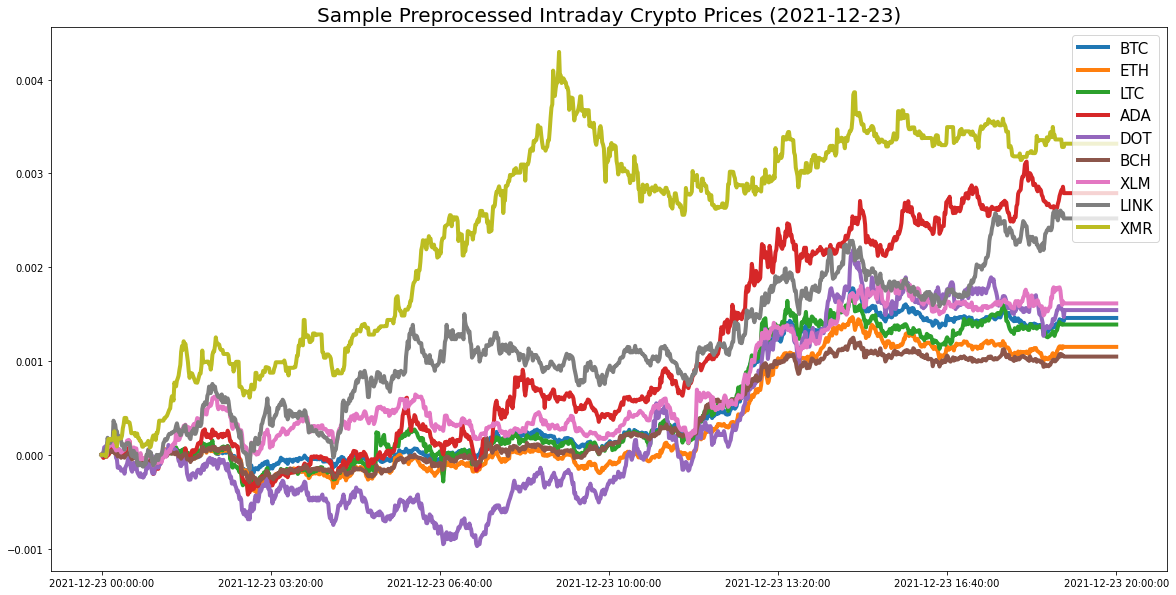

In [13]:
crypto_abbrevs=['BTC','ETH','LTC','ADA','DOT','BCH','XLM','LINK','BNB','XMR']
date='2021-12-23'
intraday_crypto_prices_df=FetchPrices(crypto_abbrevs,'crypto').fetch_intraday_prices_df(date)
plot_df(intraday_crypto_prices_df, 
        title ='Sample Preprocessed Intraday Crypto Prices ({})'.format(date),
        linewidth=4.0)

## Lead Lag Matrix

In [14]:
Crypto_CA=CyclicityAnalysis(intraday_crypto_prices_df)
Crypto_CA.plot_lead_lag_df()

## Top 10 Leader Follower Pairs

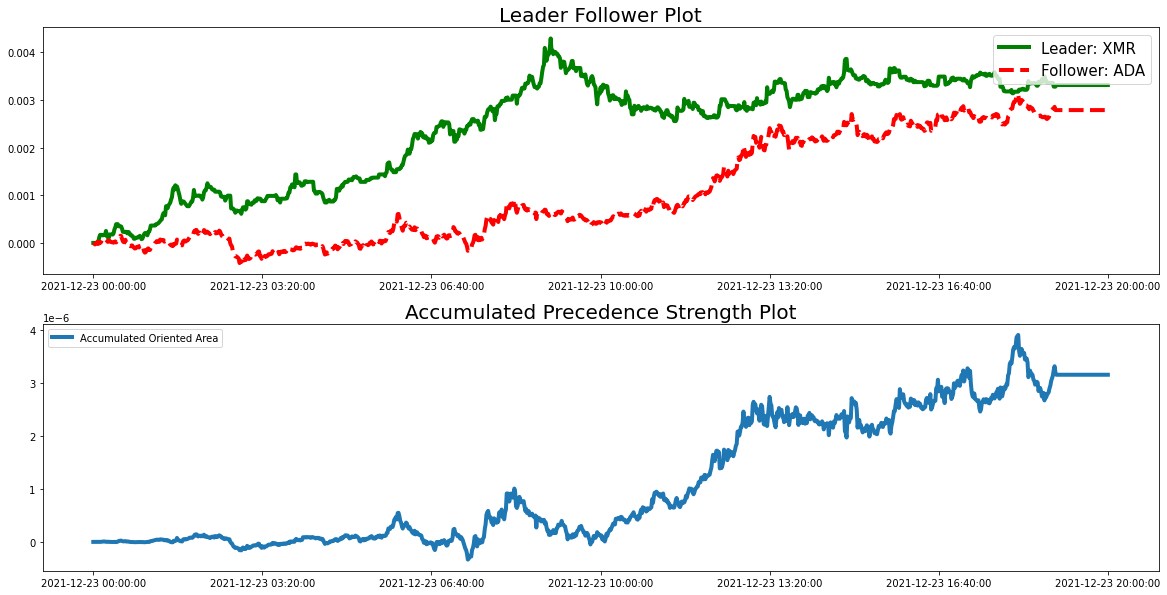

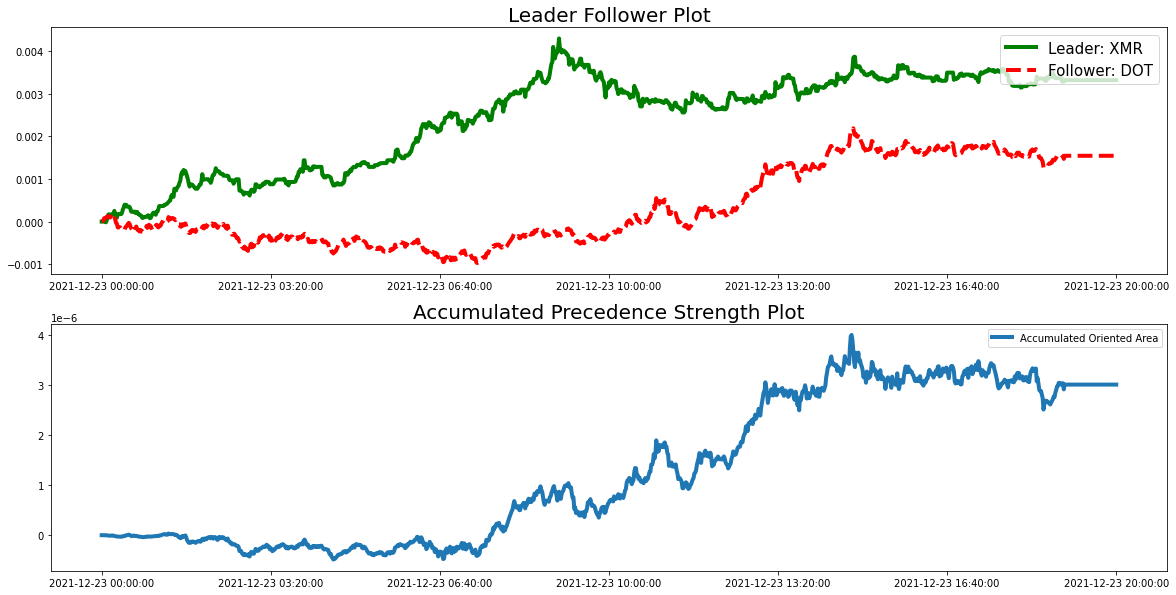

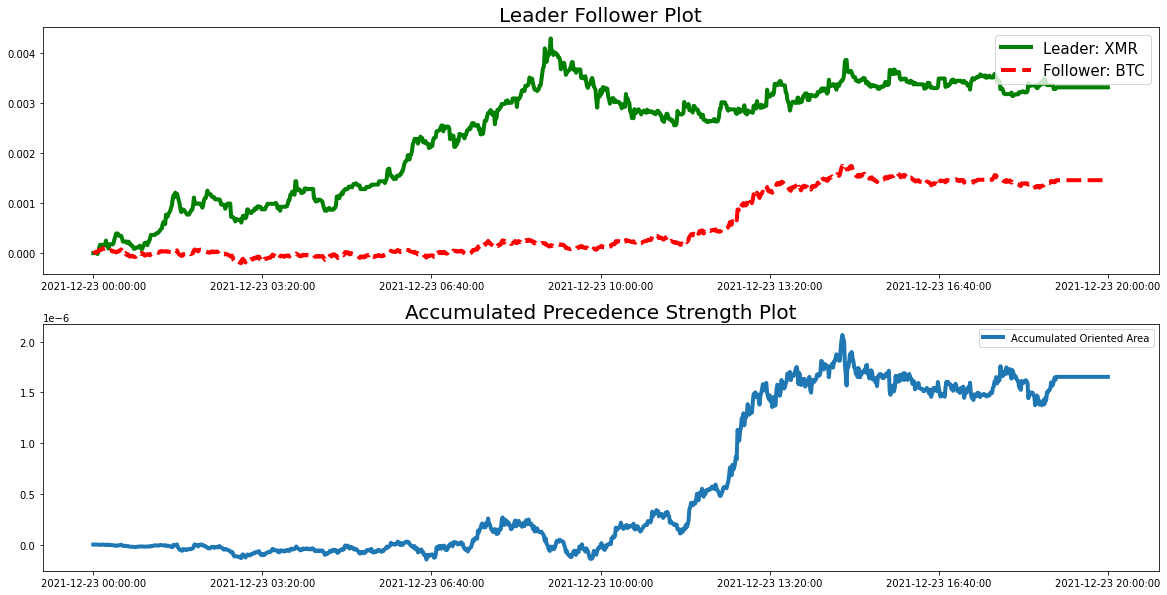

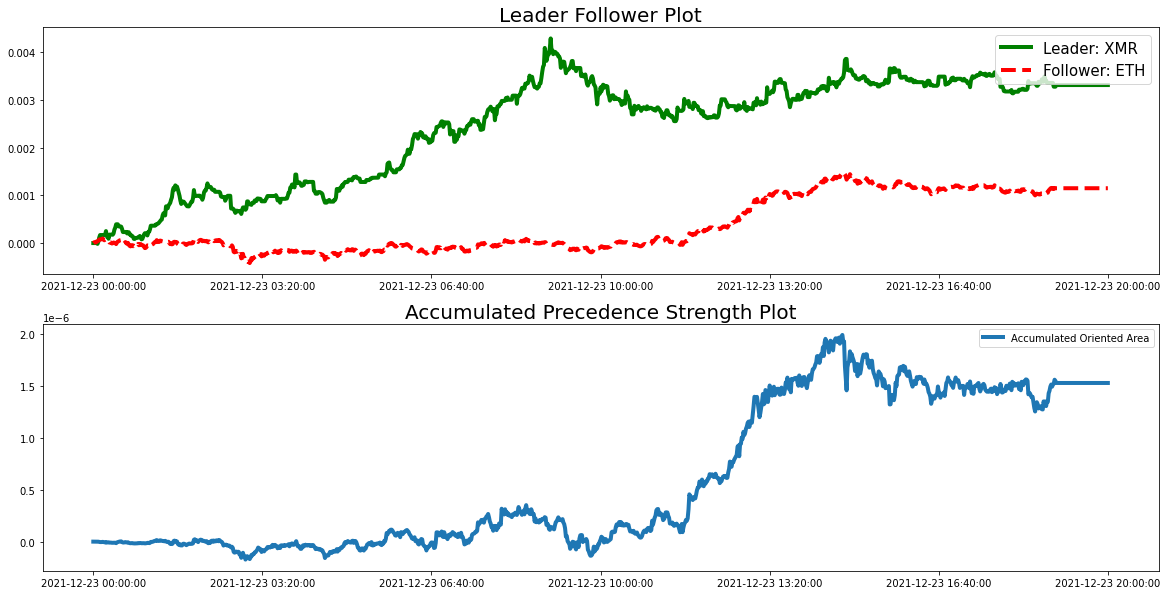

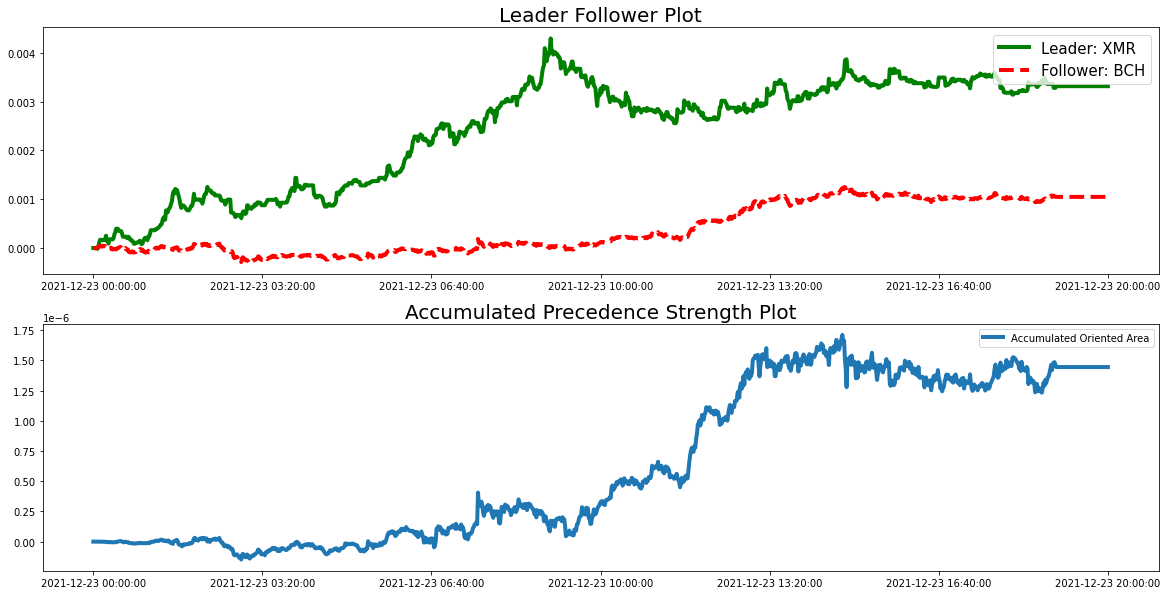

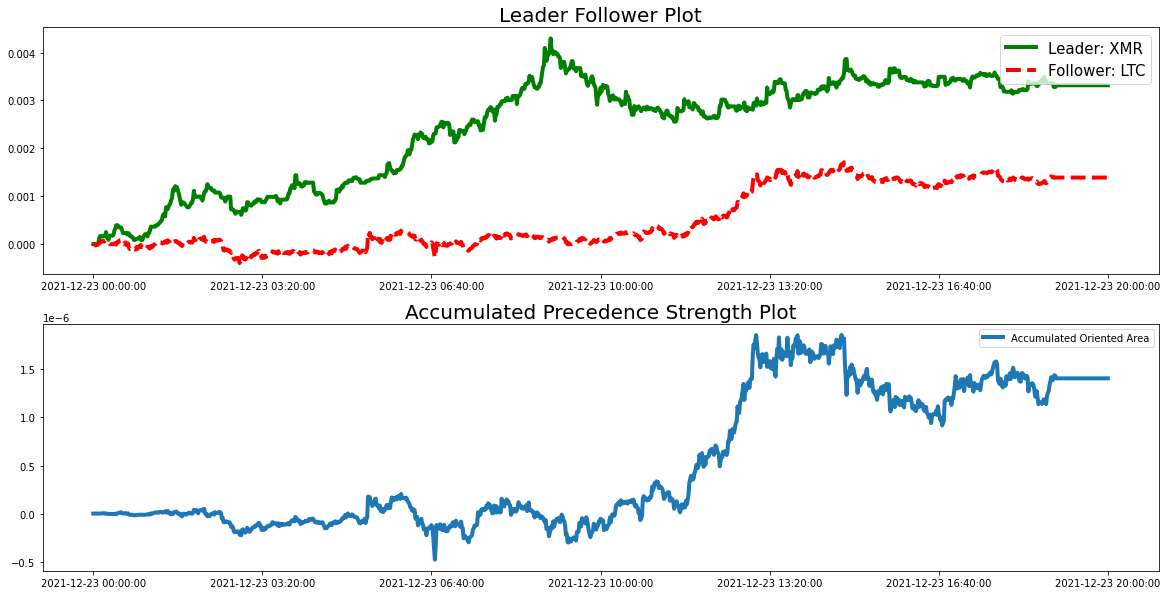

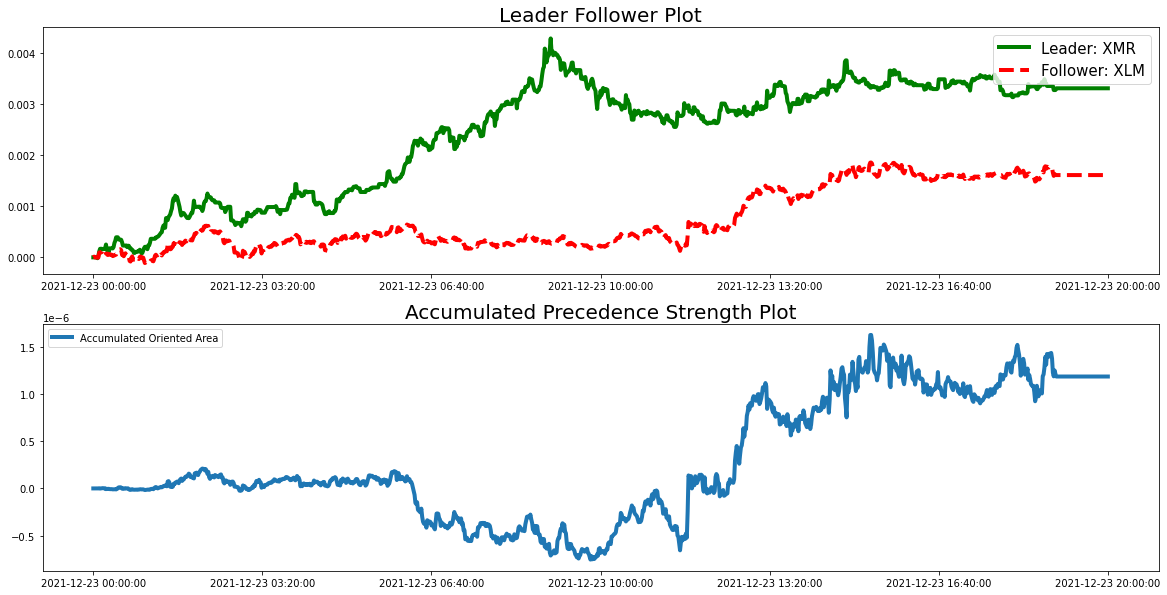

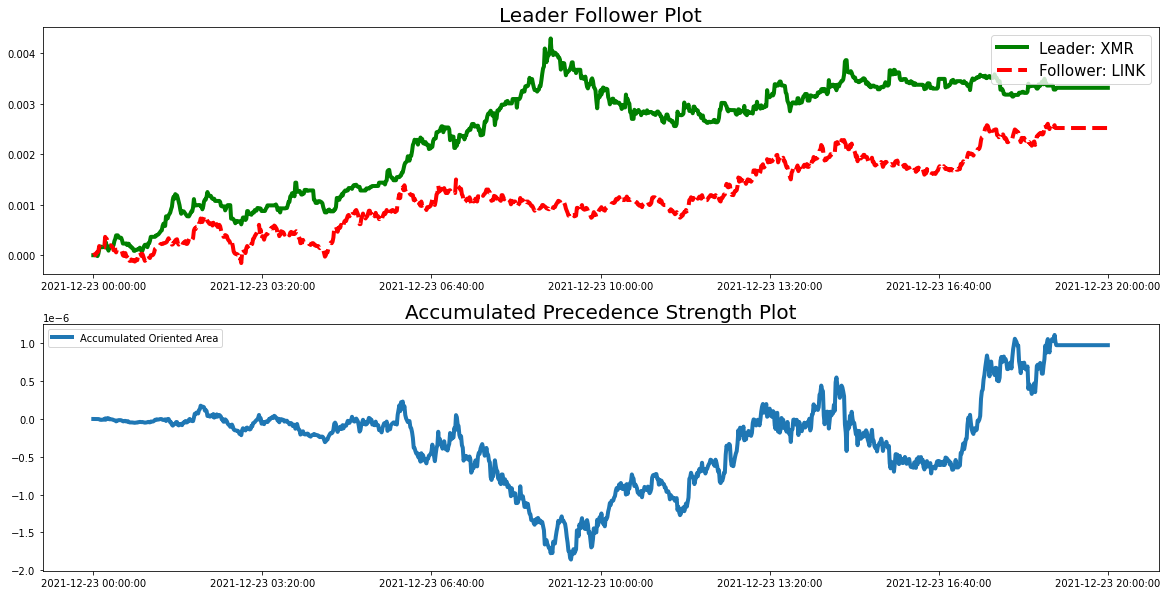

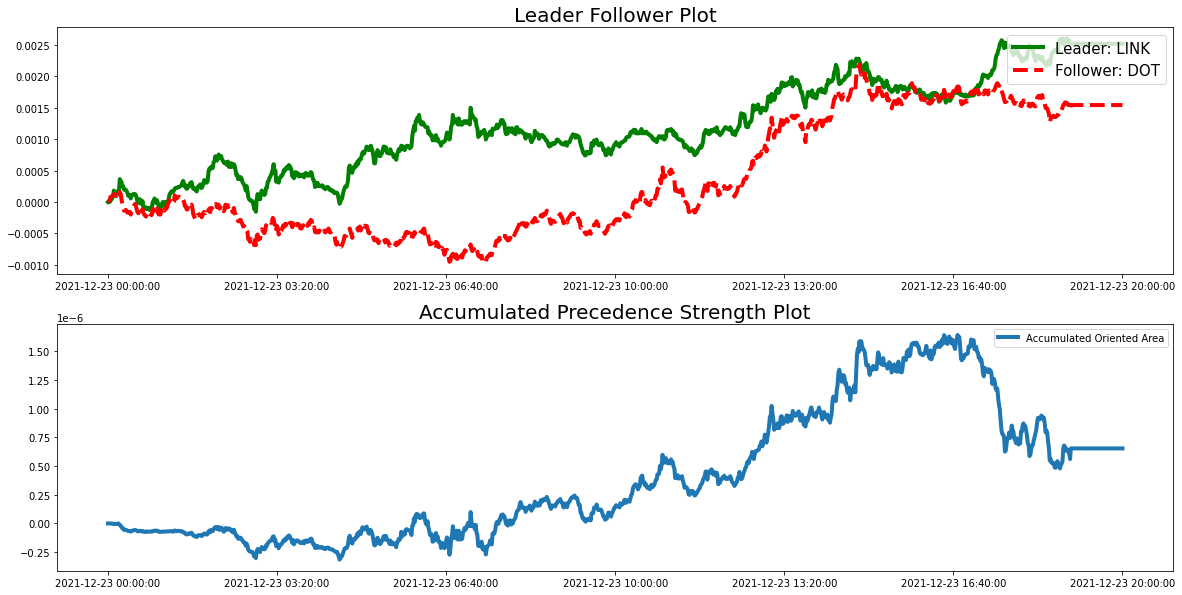

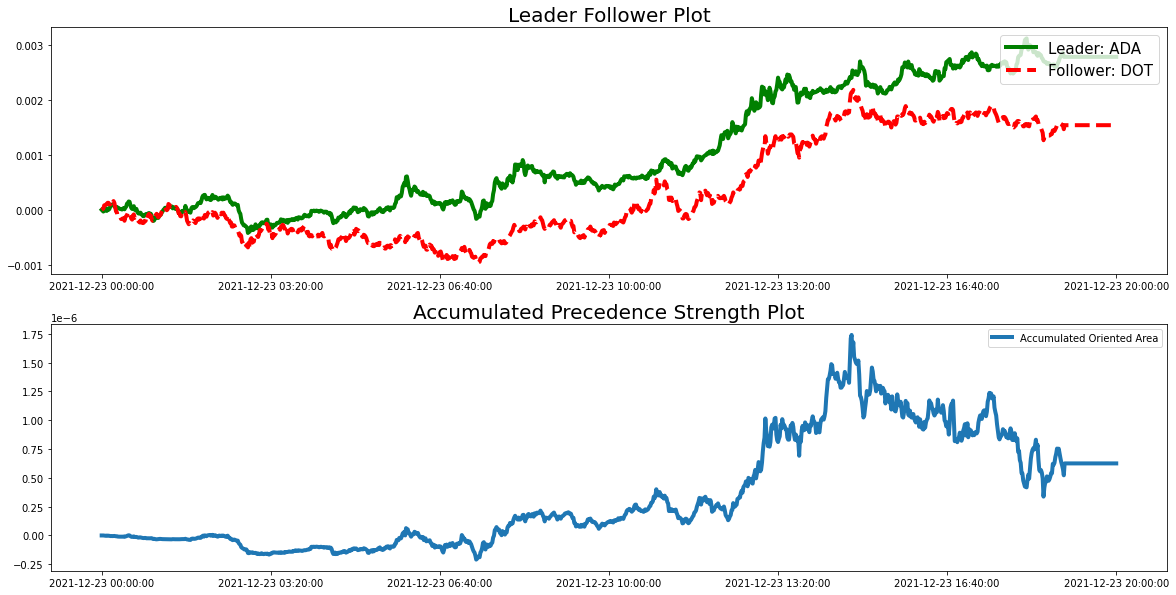

In [15]:
for pair in Crypto_CA.get_topN_leader_follower_pairs(N=10):
    leader,follower=pair
    plot_leader_follower_relationship(intraday_crypto_prices_df, 
                                      leader, 
                                      follower, 
                                      figsize=(20,10),
                                      include_accumulated_oriented_area_plot=True)

## Strong Frequency Count Matrix for 2021

In [16]:
def crypto_follower_intraday_analysis(crypto_abbrevs, start_date = '2021-01-01', end_date = today):
    save_directory='Crypto_Top_Intraday_Leader_Followers'
    
    LFA=LeaderFollowerFrequencyAnalysis(crypto_abbrevs,'crypto',start_date,end_date,save_directory)
    
    if end_date == today:
        LFA.get_topN_intraday_leader_follower_df(date=end_date,update=True)
        
    LFA.plot_strong_frequency_count_df(title='Crypto Frequency Matrix ({} - {})'.format(start_date,end_date))
    return LFA.strong_leader_follower_relationship_days_df


start_date, end_date ='2021-12-21', '2021-12-23'
strong_leader_follower_relationship_days_df=crypto_follower_intraday_analysis(crypto_abbrevs, start_date, end_date)

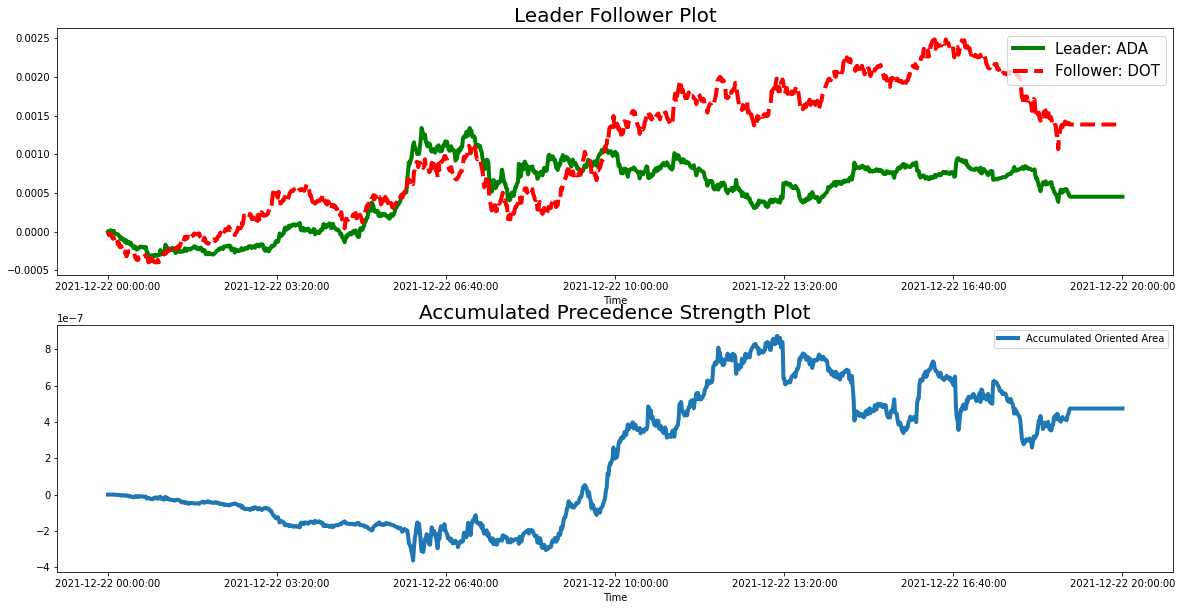

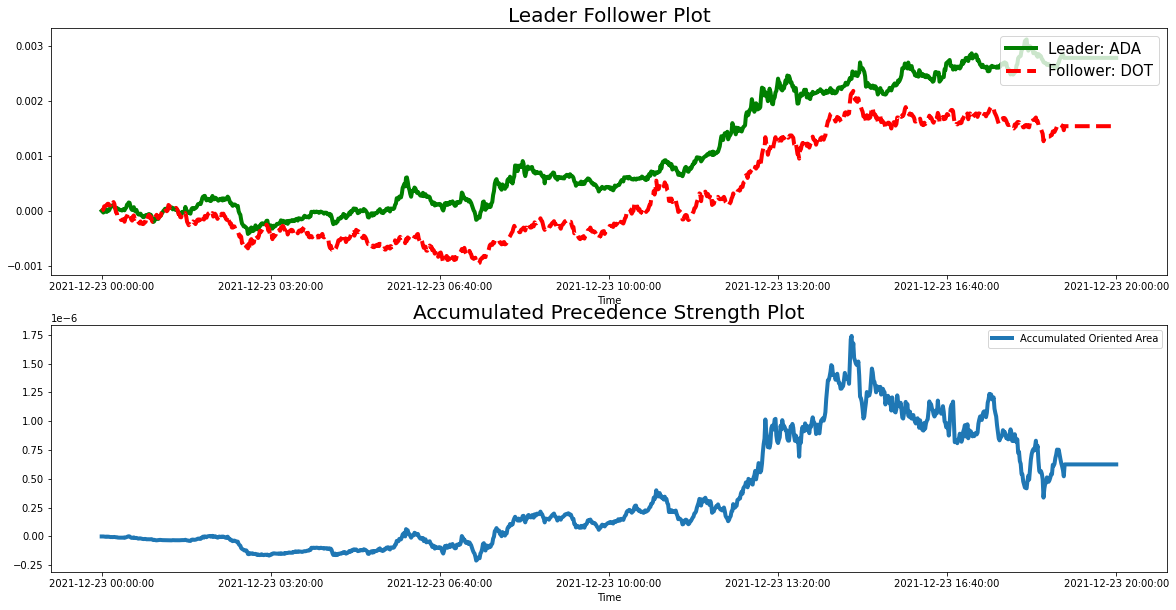

In [17]:
index=0
leader,follower,strong_dates = strong_leader_follower_relationship_days_df.iloc[index]['Leader'],\
strong_leader_follower_relationship_days_df.iloc[index]['Follower'],\
strong_leader_follower_relationship_days_df.iloc[index]['Strong Leader Follower Dates']
for date in strong_dates[:10]:
    df=FetchPrices([leader,follower],'crypto').fetch_intraday_prices_df(date)
    plot_leader_follower_relationship(df,leader,follower,include_accumulated_oriented_area_plot=True,figsize=(20,10))